In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import timeit
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
import itertools
from sklearn.model_selection import GridSearchCV


In [2]:
warnings.filterwarnings("ignore")

## **Khởi tạo bộ scalers**

In [3]:
# Standardization techniques
scalers = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer(), PowerTransformer()]

## **Chia bộ dữ liệu thành 2 phần train và test**

*8-2 với bộ dữ liệu 1k và 9-1 với bộ dữ liệu 10k*

In [4]:
data = pd.read_csv('data/data extracted/data_fe_1000_part_1.csv')
data1_test = data.head(200)
data1_train = data.drop(range(200))
data1_train = data1_train.reset_index(drop=True)
data1_train.head()

,gold_difference,team_win,herald_difference,dragon_difference,turret_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_lane,score_role
0,-4079.0,0,0,1.0,0.0,1.50,-5.33,-4.50,1.67,1.00,-1.0,0.0
1,2280.0,0,2,1.0,-1.0,-1.00,2.00,3.75,1.00,2.00,1.0,-2.0
2,4872.0,1,0,0.0,0.0,-1.00,3.75,7.25,2.00,2.25,-2.0,0.0
3,3222.0,1,2,1.0,-3.0,5.67,0.00,2.50,-6.33,-6.50,-3.0,0.0
4,-8739.0,0,-2,-1.0,1.0,-2.00,0.00,-1.93,-5.00,-6.00,0.0,1.0


In [5]:
data = pd.read_csv('data/data_fe.csv')
data10_test = data.head(1000)
data10_train = data.drop(range(1000))
data10_train = data10_train.reset_index(drop=True)
data10_train.head()

,gold_difference,team_win,herald_difference,dragon_difference,turret_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_lane,score_role
0,5063.0,1,2,0.0,0.0,3.00,8.40,7.83,0.33,1.50,0.0,0.0
1,-416.0,0,2,1.0,0.0,0.75,3.50,2.00,-8.67,-4.20,0.0,-2.0
2,1081.0,0,2,0.0,-1.0,-3.75,1.20,0.66,-3.00,-0.50,1.0,-1.0
3,-8513.0,0,-1,1.0,1.0,-3.67,-9.75,-0.50,-8.00,-11.00,1.0,-1.0
4,-2500.0,0,2,1.0,1.0,-2.50,-1.33,-1.00,1.17,-4.33,1.0,0.0


In [6]:
data_outlierhanded = pd.read_csv('data/data_fe_cleaned.csv')
data10_train_outlierhanded = data_outlierhanded.drop(range(1000))
data10_train_outlierhanded = data_outlierhanded.reset_index(drop=True)
data10_train_outlierhanded.head()

,gold_difference,team_win,herald_difference,dragon_difference,turret_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_lane,score_role
0,9038.0,1,2,-1.0,-3.0,0.00,12.40,-3.0,11.67,3.40,2.0,-1.0
1,4860.0,0,2,-2.0,-3.0,2.83,0.50,-1.0,1.00,-2.00,-1.0,0.0
2,4552.0,1,0,-1.0,0.0,1.50,-0.17,1.0,0.67,2.00,-1.0,1.0
3,-608.0,1,1,0.0,0.0,-1.50,0.57,1.0,-0.83,-3.83,3.0,0.0
4,-6015.0,0,-2,1.0,2.0,2.00,-5.00,0.0,-5.50,-6.00,0.0,1.0


### **Hàm thử nghiệm để tìm ra thuật toán tối ưu cho bài toán**

In [7]:
def Find_model(data, models):  
    
    kf = KFold(n_splits=5, shuffle=False)
    X = data.drop('team_win', axis=1)
    y = data['team_win']
    
    model_list = []

    # Loop through models and scalers
    for model in models:
        elapsed_time = {}
        acc_scores = {}
        for scaler in scalers:
            start_time = timeit.default_timer()
            acc = []
            
            # Scale the data
            X_scaled = scaler.fit_transform(X)
            
            # Loop through folds and calculate average accuracy
            for train_index, test_index in kf.split(X_scaled):
                X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Train the model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions on the testing data
                y_pred = model.predict(X_test_scaled)
                
                # Calculate the accuracy of the predictions
                acc.append(accuracy_score(y_test, y_pred))
            
            # Append the accuracy score to the list for this model and scaler
            model_name = f"{type(model).__name__} ({type(scaler).__name__})"
            acc_scores[model_name] = np.mean(acc)
            elapsed_time[model_name] = timeit.default_timer() - start_time
        
        best_model_name = max(acc_scores, key=acc_scores.get)
        model_list.append((best_model_name, acc_scores[best_model_name], elapsed_time[best_model_name]))
        
    sorted_models = sorted(model_list, key=lambda x: (-x[1], x[2]))
        
    return sorted_models[0]
    

### **Thử nghiệm trên tập dữ liệu 1k samples và 10k samples đã qua xử lý**

#### *1. Khởi tạo bộ models thử nghiệm*

In [8]:
models = [LogisticRegression(random_state=42), LinearDiscriminantAnalysis(), GaussianNB()
          , RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), XGBClassifier(random_state=42), GaussianNB(),
          GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), BaggingClassifier(random_state=42),
          KNeighborsClassifier()]

#### *2. Thử nghiệm để tìm mô hình tốt nhất trên tập dữ liệu 1k samples*

In [9]:
result1 = Find_model(data1_train, models)

In [10]:
results = []
results.append(['part 1', result1[0], result1[1], result1[2]])
for i in range(1,10):
    filename = f"data/data extracted/data_fe_1000_part_{i+1}.csv"
    fd = f'part {i+1}'
    data = pd.read_csv(filename)
    result = Find_model(data, models)
    results.append([fd, result[0], result[1], result[2]])

# Tạo DataFrame từ danh sách kết quả
df_rs1 = pd.DataFrame(results, columns=["File", "Best Model", "Accuracy", "Elapsed Time"])
df_rs1.head(10)

,File,Best Model,Accuracy,Elapsed Time
0,part 1,LinearDiscriminantAnalysis (MinMaxScaler),0.77375,0.037144
1,part 2,LogisticRegression (StandardScaler),0.75400,0.023964
2,part 3,LogisticRegression (RobustScaler),0.74500,0.023649
3,part 4,LogisticRegression (StandardScaler),0.76700,0.022410
4,part 5,LinearDiscriminantAnalysis (QuantileTransformer),0.78900,0.023151
5,part 6,LogisticRegression (PowerTransformer),0.76700,0.043663
6,part 7,GaussianNB (MinMaxScaler),0.75900,0.011936
7,part 8,GaussianNB (QuantileTransformer),0.77000,0.020964
8,part 9,LogisticRegression (MaxAbsScaler),0.77500,0.029586
9,part 10,LogisticRegression (StandardScaler),0.76500,0.024884


#### *3. Thử nghiệm để tìm mô hình tốt nhất trên tập dữ liệu 10k samples*

##### 3.1. Thử nghiệm trên tập dữ liệu không xử lý ngoại lệ

In [11]:
result10 = Find_model(data10_train, models)
results10 = []
results10.append(['N', result10[0], result10[1], result10[2]])

##### 3.2. Thử nghiệm trên tập dữ liệu đã xử lý ngoại lệ

In [12]:
result10_outlierhanded = Find_model(data10_train_outlierhanded, models)
results10.append(['Y', result10_outlierhanded[0], result10_outlierhanded[1], result10_outlierhanded[2]])

In [13]:
df_rs1 = pd.DataFrame(results10, columns=["Ourlier Handle", "Best Model", "Accuracy", "Elapsed Time"])
df_rs1.head(10)

,Ourlier Handle,Best Model,Accuracy,Elapsed Time
0,N,LogisticRegression (MaxAbsScaler),0.761759,0.121095
1,Y,LogisticRegression (MaxAbsScaler),0.757959,0.094389


***Nhận xét:***

1. *LinearDiscriminantAnalysis cho tỉ lệ chính xác và thời gian xử lý nhanh nhất trong trường hợp tập dữ liệu nhỏ (thử nghiệm trên 10 file 1k samples)*

2. *LogisticRegression cho tỉ lệ chính xác và thời gian xử lý vượt trội hơn so với các mô hình còn lại trong trường hợp tập dữ liệu lớn (thử nghiệm trên file 10k samples)*

3. *Kết quả thử nghiệm cho thấy việc xử lý ngoại lệ là không cần thiết vì làm giảm độ chính xác từ 0.7617 xuống 0.7579*

> ***Nên sử dụng LinearDiscriminantAnalysis cho trường hợp dữ liệu nhỏ (1k samples) và LogisticRegression cho trường hợp dữ liệu lớn (10k samples), không cần xử lý ngoại lệ***

### **Thử nghiệm loại bớt đặc trưng trên bộ dữ liệu đã xử lý với 2 mô hình được chọn**

*Hàm lựa chọn đặc trưng dựa trên 2 tập dữ liệu*

In [14]:
def feature_selection(data, model_for_data, min_acc_score):
    # Danh sách các trường bạn muốn giữ nguyên
    keep_columns = ['team_win', 'kda_difference_top', 'kda_difference_jungle', 'kda_difference_mid', 'kda_difference_ad', 'kda_difference_sp']
    # Danh sách các trường bạn muốn bỏ đi
    drop_columns = [col for col in data.columns if col not in keep_columns]

    # Duyệt qua các tổ hợp các đặc trưng bằng cách bỏ đi từ 1 đến n đặc trưng
    results = []
    for i in range(1, len(drop_columns)+1):
        for subset in itertools.combinations(drop_columns, i):
            # Bỏ đi các đặc trưng trong tổ hợp hiện tại
            subset_indices = [drop_columns.index(feature) for feature in subset]
            subset_data = data.drop(columns=[drop_columns[i] for i in subset_indices])
            model = Find_model(subset_data, model_for_data)[0]
            acc_score = Find_model(subset_data, model_for_data)[1]
            eslaped_time = Find_model(subset_data, model_for_data)[2]
            results.append((subset, model, acc_score, eslaped_time))

    sorted_models = sorted(results, key=lambda x: x[2], reverse=True)
    if (sorted_models[0][2] >= min_acc_score):
        print(f"{sorted_models[0][0]} - Model: {sorted_models[0][1]} - Acc Score: {sorted_models[0][2]*100:.4f}% - Eslaped Time: {sorted_models[0][3]}")
        return sorted_models[0][1]
    else:
        print(None)
        return None


#### *1. Khởi tạo lại bộ mô hình đã chọn: LinearDiscriminantAnalysis cho tập dữ liệu 1k samples, Logistic Regression cho tập dữ liệu 10k samples*

In [15]:
model_for_1ksamples = [LinearDiscriminantAnalysis()]
model_for_10ksamples = [LogisticRegression()]

#### *2. Thử nghiệm lựa chọn đặc trưng: loại bỏ từng tổ hợp để xem kết quả sau loại bỏ thì độ chính xác có cao hơn không*

In [16]:
best_model1 = feature_selection(data1_train, model_for_1ksamples, result1[1])
best_model10 = feature_selection(data10_train, model_for_10ksamples, result10[1])

('turret_difference', 'score_lane') - Model: LinearDiscriminantAnalysis (PowerTransformer) - Acc Score: 77.6250% - Eslaped Time: 0.03289309999672696
('turret_difference', 'score_lane') - Model: LogisticRegression (MinMaxScaler) - Acc Score: 76.2979% - Eslaped Time: 0.16723360000469256


**Nhận xét** Việc lựa chọn đặc trưng làm tăng tỷ lệ dự đoán chính xác:
- Với tập dữ liệu 1k:  tăng từ 77,375% -> 77,6250%
- Với tập dữ liệu 10k: tăng từ 76,175% -> 76,2979%

#### *3. Xóa các đặc trưng không cần thiết để tăng độ chính xác của tập dữ liệu*

In [17]:
data1_train = data1_train.drop(columns=['turret_difference', 'score_lane'], axis=1)
data1_test = data1_test.drop(columns=['turret_difference', 'score_lane'], axis=1)

In [18]:
data1_train.head()

,gold_difference,team_win,herald_difference,dragon_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_role
0,-4079.0,0,0,1.0,1.50,-5.33,-4.50,1.67,1.00,0.0
1,2280.0,0,2,1.0,-1.00,2.00,3.75,1.00,2.00,-2.0
2,4872.0,1,0,0.0,-1.00,3.75,7.25,2.00,2.25,0.0
3,3222.0,1,2,1.0,5.67,0.00,2.50,-6.33,-6.50,0.0
4,-8739.0,0,-2,-1.0,-2.00,0.00,-1.93,-5.00,-6.00,1.0


In [19]:
data10_train = data10_train.drop(columns=['turret_difference','score_lane'], axis=1)

In [20]:
data10_test = data10_test.drop(columns=['turret_difference','score_lane'], axis=1)

In [21]:
data10_train.head()

,gold_difference,team_win,herald_difference,dragon_difference,kda_difference_top,kda_difference_jungle,kda_difference_mid,kda_difference_ad,kda_difference_sp,score_role
0,5063.0,1,2,0.0,3.00,8.40,7.83,0.33,1.50,0.0
1,-416.0,0,2,1.0,0.75,3.50,2.00,-8.67,-4.20,-2.0
2,1081.0,0,2,0.0,-3.75,1.20,0.66,-3.00,-0.50,-1.0
3,-8513.0,0,-1,1.0,-3.67,-9.75,-0.50,-8.00,-11.00,-1.0
4,-2500.0,0,2,1.0,-2.50,-1.33,-1.00,1.17,-4.33,0.0


#### *4. Định nghĩa pineline tốt nhất*

In [22]:
def get_pineline(model_name):
    model_str, scaler_str = model_name.split(' (')
    model_name = model_str.strip()
    scaler_name = scaler_str[:-1].strip()
    return model_name, scaler_name

In [23]:
model_name1, scaler_name1= get_pineline(best_model1)

best_pineline_for_1ksamples = Pipeline([
    ('scaler', eval(scaler_name1)()),
    ('model', eval(model_name1)())
])

model_name10, scaler_name10= get_pineline(best_model10)

best_pineline_for_10ksamples = Pipeline([
    ('scaler', eval(scaler_name10)()),
    ('model', eval(model_name10)())
])

In [24]:
best_pineline_for_1ksamples

Pipeline(steps=[('scaler', PowerTransformer()),
                ('model', LinearDiscriminantAnalysis())])

In [25]:
best_pineline_for_10ksamples

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

***Nhận xét:***
1. *Đối với tập dữ liệu 1k samples, việc loại bỏ bớt các đặc trưng có thể làm tăng độ chính xác (0.25%), tuy nhiên không nhiều.*
2. *Đối với tập dữ liệu 10k samples, việc loại bỏ đặc trưng có thể làm tăng độ chính xác (0.1229%)*
> Thực hiện việc lựa chọn đặc trưng cho 2 bộ dữ liệu

## **Trực quan hóa dữ liệu trước và sau khi scale**

*Hàm trực quan hóa dữ liệu trước và sau khi scaler*

In [26]:
def plot_histogram(data, scaler):
    # Sao chép dữ liệu ban đầu]
    data = data.drop('team_win',axis= 1)
    data_scaled = data.copy()

    # Scale dữ liệu
    data_scaled[data.columns] = scaler.fit_transform(data)

    for col in data.columns:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        # Vẽ histogram cho dữ liệu gốc
        axes[0].hist(data[col], bins=20, alpha=0.7, label="Original", color="blue")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Frequency")
        axes[0].set_title("Histogram: " + col + " (Original)")
        axes[0].legend()

        # Vẽ histogram cho dữ liệu đã được scale
        axes[1].hist(data_scaled[col], bins=20, alpha=0.7, label="Scaled", color="red")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel("Frequency")
        axes[1].set_title("Histogram: " + col + " (Scaled)")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

*1. Trực quan hóa dữ liệu trên file 1k samples*

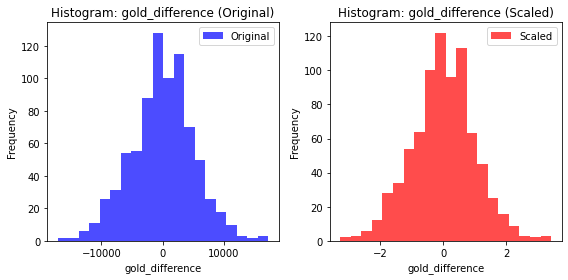

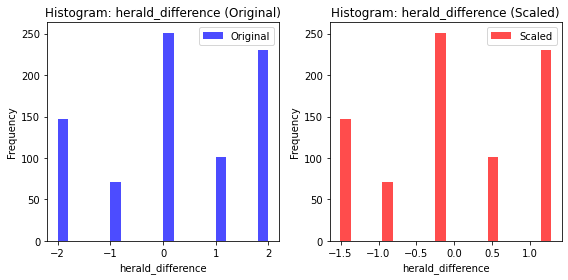

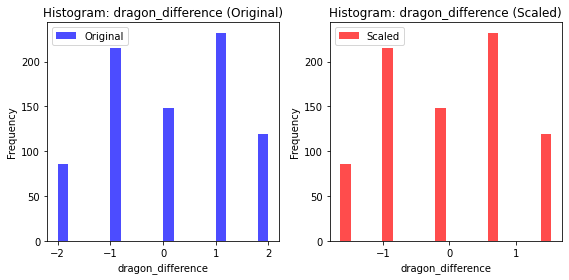

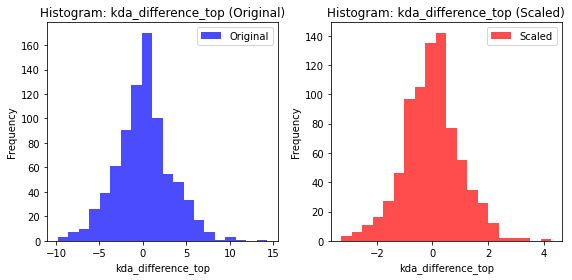

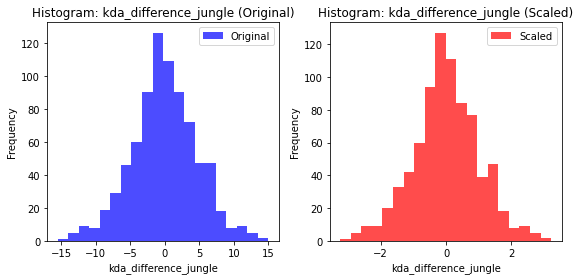

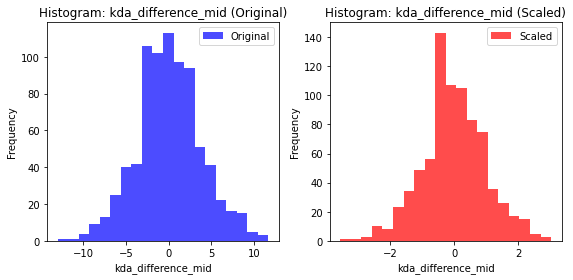

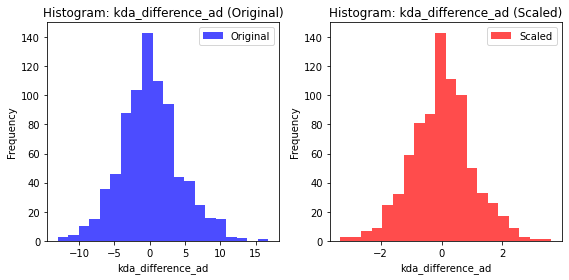

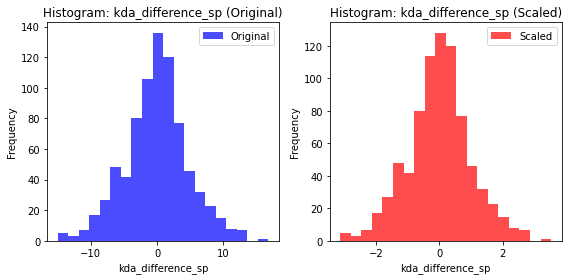

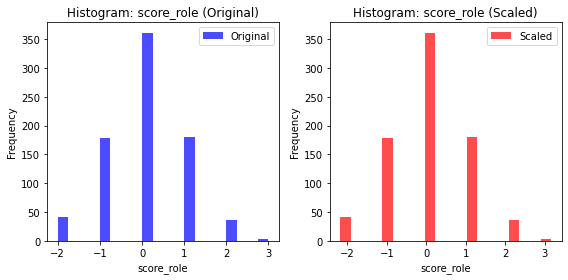

In [27]:
plot_histogram(data1_train, best_pineline_for_1ksamples.named_steps['scaler'])

2. *Trực quan hóa dữ liệu trên tập dữ liệu 10k samples*

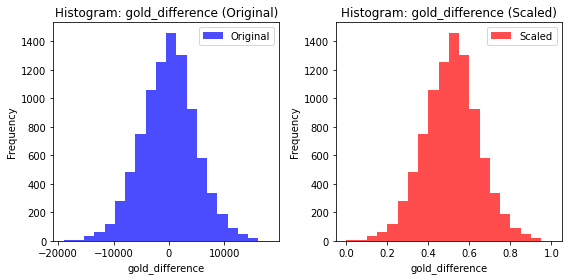

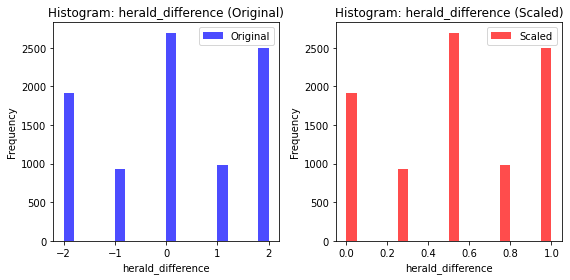

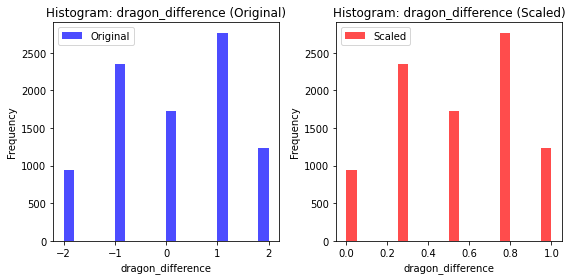

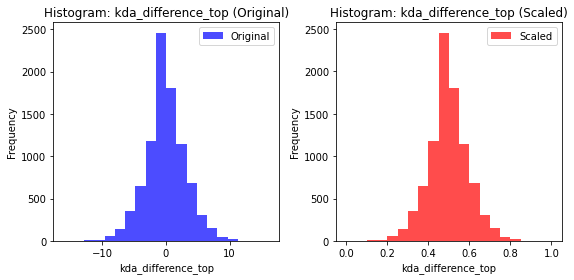

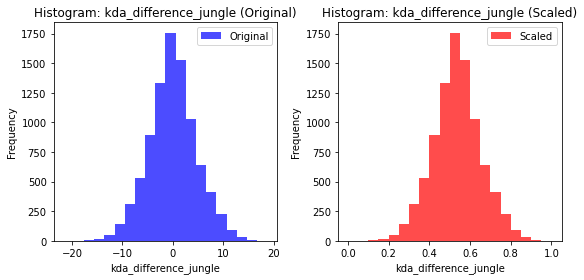

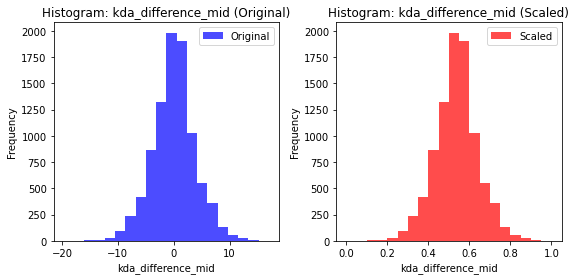

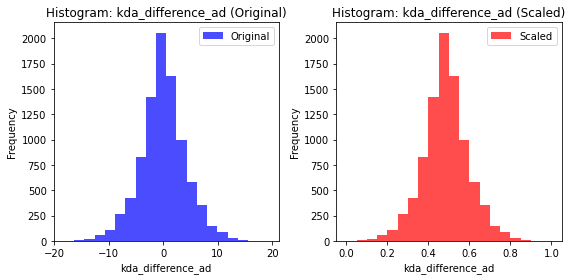

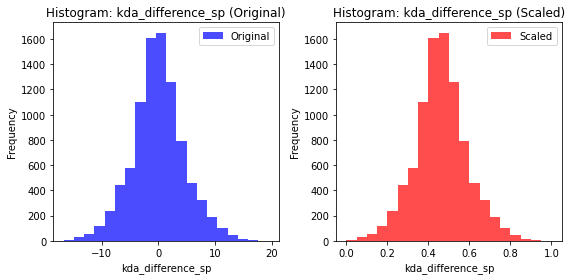

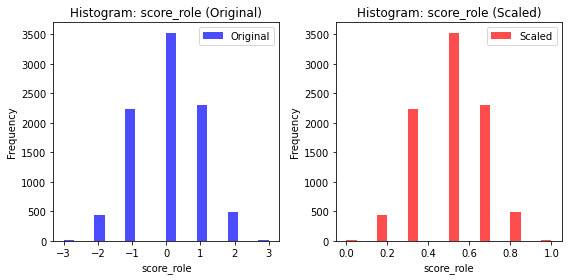

In [28]:
plot_histogram(data10_train, best_pineline_for_10ksamples.named_steps['scaler'])

### **Xây dựng mô hình tính tỉ lệ thắng cho mỗi trận LOL sử dụng 5 fold cross validation trên các tập dữ liệu 1k và 10k. Tính AUC để đánh giá tỉ lệ dự đoán của mô hình**

#### *Hàm tính tỷ lệ thắng với Kfolds validation và đánh giá bằng AUC*

In [29]:
def AUC_roc(pipeline, data):
    X = data.drop(['team_win'], axis=1)
    y = data['team_win']
    j = 0

    elapsed_times = 0
    X_cols = X.columns.tolist()

    for i, model in enumerate(pipeline):
        auc_scores = []
        
        X_transformed = pipeline.named_steps['scaler'].fit_transform(X)
        kf = KFold(n_splits=5, shuffle=False)
        for j, (train_index, test_index) in enumerate(kf.split(X_transformed)):
            start_time = timeit.default_timer()
            X_train_scaled, X_test_scaled = X_transformed[train_index], X_transformed[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf = pipeline.named_steps['model']
            
            clf.fit(X_train_scaled, y_train)
                    
            y_pred = clf.predict(X_test_scaled)
            
            # Predict the win probability for the test set
            win_prob = clf.predict_proba(X_test_scaled)[:, 1]
            
            elapsed_time = timeit.default_timer() - start_time

            # Convert win probability to win percentage
            win_percentages = win_prob * 100
            auc_score = roc_auc_score(y_test, win_prob)
            
            auc_scores.append(auc_score)

            elapsed_times += elapsed_time
        
    print(f"Mean AUC Score: {np.mean(auc_scores)}, Elapsed_time: {elapsed_times}")
    return np.mean(auc_scores), elapsed_times

*Tính tỷ lệ thắng và đánh giá AUC trên file 1k samples*

In [30]:
rs_auc = []

In [31]:
auc_scores1, elapsed_times1 = AUC_roc(best_pineline_for_1ksamples, data1_train)
rs_auc.append(['1k samples', auc_scores1, elapsed_times1])

Mean AUC Score: 0.8553619591602724, Elapsed_time: 0.03477440001734067


*Tính tỷ lệ thắng và đánh giá AUC trên file 10k samples*

In [32]:
auc_scores10, elapsed_times10 = AUC_roc(best_pineline_for_10ksamples, data10_train)
rs_auc.append(['10k samples', auc_scores10, elapsed_times10])

Mean AUC Score: 0.8485286946921431, Elapsed_time: 0.3124422999972012


In [33]:
df_rs1 = pd.DataFrame(rs_auc, columns=["Data", "AUC Score", "Elapsed Time"])
df_rs1.head(10)

,Data,AUC Score,Elapsed Time
0,1k samples,0.855362,0.034774
1,10k samples,0.848529,0.312442


#### **Tìm bộ tham số tối ưu cho mô hình**

*Hàm tìm bộ tham số tối ưu*

In [34]:
def find_best_parameters(data, pipeline, param_grid, X_test, y_test, output_file):
    # # Load the data
    # data = pd.read_csv(data_file)
    
    # # Split the data into features (X) and target (y)
    X = data.drop('team_win', axis=1)
    y = data['team_win']
    
    
    # Perform grid search with k-fold cross-validation on training set
    kfold = KFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc')
    grid_search.fit(X, y)
    
    # Print the best parameters and the corresponding AUC score
    print("Best Parameters:", grid_search.best_params_)
    print("Best AUC on Train Set:", grid_search.best_score_)
    
    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y, grid_search.predict(X))
    print("Accuracy on Train Set:", train_accuracy)
        
    # # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    win_prob = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, win_prob)
    accuracy = accuracy_score(y_test, best_model.predict(X_test))  # Calculate accuracy on test set
    print("AUC on Test Set:", auc)
    print("Accuracy on Test Set:", accuracy)
    
    # Save the predictions to the output file
    with open(output_file, 'w') as file:
        file.write("team_win,win_prob\n")  # Write header to the file
        for i in range(len(y_test)):
            file.write(f"{y_test.iloc[i]},{win_prob[i]}\n")
    
    return grid_search.best_params_, grid_search.best_score_, train_accuracy, auc, accuracy

*Hàm vẽ ROC Curve*

In [35]:
def plot_roc_curve_from_files(file_paths, labels):
    # Iterate over the file paths and labels
    for file_path, label in zip(file_paths, labels):
        # Load the result data from the CSV file
        result = pd.read_csv(file_path)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(result['team_win'], result['win_prob'])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve with file name annotation and different colors
        plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f) - %s' % (roc_auc, label))

    # Set plot properties
    plt.legend(loc="lower right")
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Show the plot with multiple ROC curves
    plt.show()


*Hàm đánh giá mô hình dự đoán tỉ lệ thắng dựa trên tập kiểm thử*

In [36]:
final = []

In [37]:
def predict(data_train, best_pipeline, param_grid, data_test, previous_score, previous_accuracy, output_file):
    X_test = data_test.drop('team_win', axis=1)
    y_test = data_test['team_win']
    best_params, following_score, following_accuracy, auc, accuracy= find_best_parameters(data_train, best_pipeline, param_grid, X_test, y_test, output_file)
    final.append([best_params, previous_score, following_score, previous_accuracy, following_accuracy, accuracy, auc])

*Tìm bộ siêu tham số tối ưu cho mô hình với tập dữ liệu 1k samples*

In [38]:
param_grid_lda = {
        'model__solver': [ 'lsqr', 'eigen'],
        'model__shrinkage': ['auto', None],
    }

predict(data1_train, best_pineline_for_1ksamples, param_grid_lda, data1_test, auc_scores1, 0.77625, 'data/results/result_1.csv')

Best Parameters: {'model__shrinkage': None, 'model__solver': 'lsqr'}
Best AUC on Train Set: 0.8555202458563986
Accuracy on Train Set: 0.78125
AUC on Test Set: 0.8607988759534323
Accuracy on Test Set: 0.755


*Tìm bộ siêu tham số tối ưu cho mô hình với tập dữ liệu 10k samples*

In [39]:
param_grid_logistic = {
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
}

predict(data10_train, best_pineline_for_10ksamples, param_grid_logistic, data10_test, auc_scores10, 0.762979,'data/results/result_10.csv')

Best Parameters: {'model__C': 1.0, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best AUC on Train Set: 0.8489778698826352
Accuracy on Train Set: 0.7627551020408163
AUC on Test Set: 0.8554181672669068
Accuracy on Test Set: 0.773


In [40]:
df_final = pd.DataFrame(final, columns=["Best Params","Previous AUC Score On Train Set", "Following AUC Score On Train Set",  "Previous Accuracy  On Train Set", "Following Accuracy  On Train Set", "Accuracy On Test Set", "AUC Score On Test Set"])
# Thiết lập tùy chọn hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# In ra head của DataFrame df_final
df_final.head()


,Best Params,Previous AUC Score On Train Set,Following AUC Score On Train Set,Previous Accuracy On Train Set,Following Accuracy On Train Set,Accuracy On Test Set,AUC Score On Test Set
0,"{'model__shrinkage': None, 'model__solver': 'lsqr'}",0.855362,0.855520,0.776250,0.781250,0.755,0.860799
1,"{'model__C': 1.0, 'model__penalty': 'l1', 'model__solver': 'liblinear'}",0.848529,0.848978,0.762979,0.762755,0.773,0.855418


*Vẽ ROC Curve cho 2 tập dữ liệu*

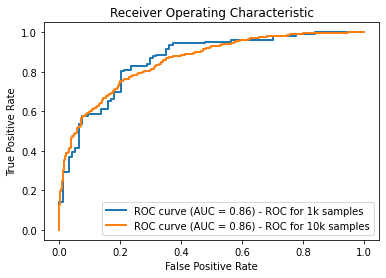

In [41]:
plot_roc_curve_from_files(['data/results/result_1.csv', 'data/results/result_10.csv'], ['ROC for 1k samples', 'ROC for 10k samples'])


#### **Trực quan hóa tỉ lệ thắng dự đoán**

*Hàm trực quan hóa tỉ lệ thắng*

In [42]:
def plot_blue_win_percentage(file_path, label):
    # Load the data from the CSV file
    data = pd.read_csv(file_path)

    # Extract the y values (blue_win_percentage)
    y = data['win_prob'].head(200)

    # Create a list of x values from 0 to the length of y
    x = list(range(len(y)))

    # Create a new figure
    plt.figure(figsize=(40, 6))

    # Plot the line
    plt.plot(x, y, label=label)

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()

*Hàm trực quan hóa tỉ lệ thắng trên 200 mẫu đầu tiên dự đoán được từ 2 bộ dữ liệu 1k và 10k mẫu trên cùng các trận*

In [43]:
def plot_blue_win_percentage(data_1, label_1, label_10):
    # Extract the y values (blue_win_percentage) for result_1
    y_1 = data_1['result_1_win_prob'].head(200)

    # Extract the y values (blue_win_percentage) for result_10
    y_10 = data_1['result_10_win_prob'].head(200)

    # Create a list of x values from 0 to the length of y_1 or y_10 (they should have the same length)
    x = list(range(len(y_1)))

    # Create a new figure
    plt.figure(figsize=(40, 6))

    # Plot the lines for result_1 and result_10
    plt.plot(x, y_1, label=label_1)
    plt.plot(x, y_10, label=label_10)

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()


*Merge dữ liệu kết quả trên tập test của 2 tập dữ liệu 1k và 10k vào và trực quan hóa để so sánh*

In [44]:
# Đọc dữ liệu từ file result_1
result_1 = pd.read_csv('data/results/result_1.csv')

# Đọc dữ liệu từ file result_10
result_10 = pd.read_csv('data/results/result_10.csv')

# Lấy 200 dòng đầu của mỗi file dữ liệu và chỉ lấy cột "win_prob"
result_1_subset = result_1.head(200)["win_prob"]
result_10_subset = result_10.head(200)["win_prob"]

# Merge hai subset lại với nhau thành DataFrame mới
merged_data = pd.DataFrame({"result_1_win_prob": result_1_subset, "result_10_win_prob": result_10_subset})

# In thông tin của merged_data
merged_data.head(10)

,result_1_win_prob,result_10_win_prob
0,0.909671,0.964098
1,0.905197,0.907650
2,0.879121,0.863207
3,0.448589,0.447696
4,0.108165,0.086509
5,0.075084,0.142676
6,0.851999,0.878946
7,0.039171,0.029031
8,0.882028,0.928749
9,0.655703,0.723787


*Trực quan hóa kết quả thu được bằng biểu đồ đường*

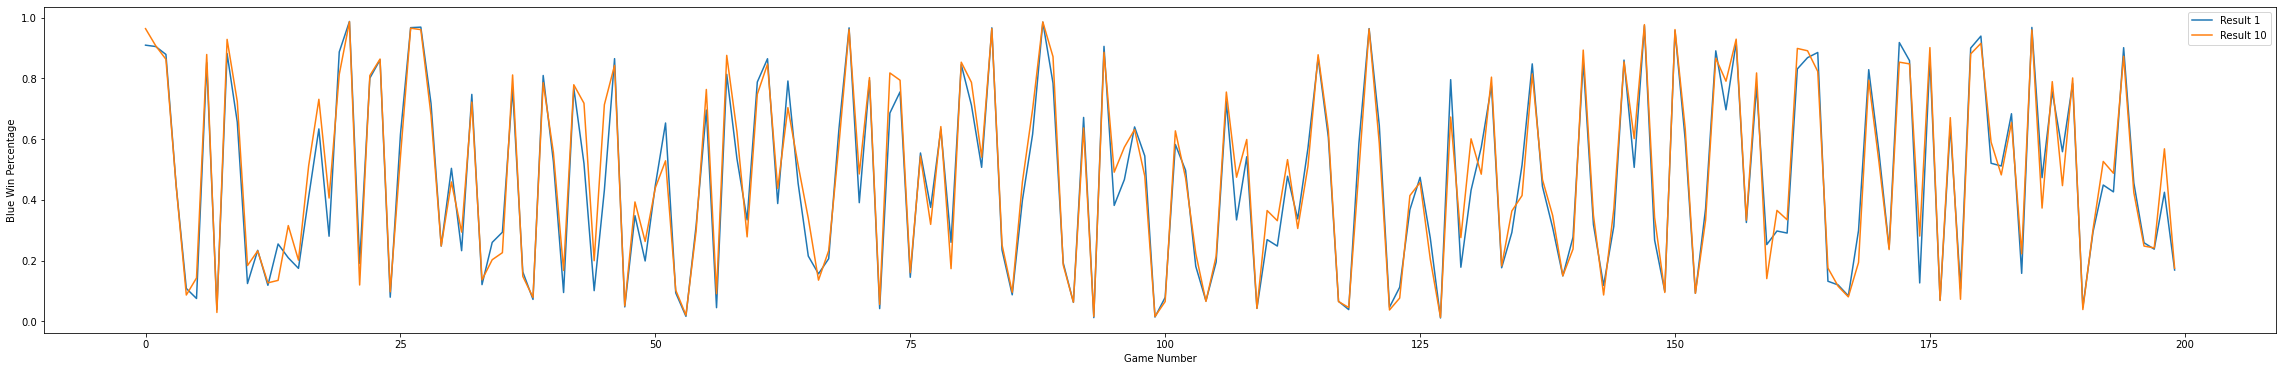

In [45]:
plot_blue_win_percentage(merged_data, "Result 1", "Result 10")